## Mounting Drive 

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


## Import Libraries 

In [ ]:
import os

import numpy as np
import cv2 
import matplotlib.pyplot as plt
import tensorflow 
import keras
import random

from sklearn.metrics import confusion_matrix
#print(np.array(y[0],dtype = np.uint8))
import sklearn.metrics

Using TensorFlow backend.


In [ ]:
from tensorflow.keras.layers import Input 
from tensorflow.keras.layers import Activation,Flatten,Reshape,Dense,Lambda,Dropout
from tensorflow.keras.layers import Convolution2D,MaxPooling2D,UpSampling2D,Conv2D,SeparableConvolution2D,DepthwiseConv2D
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.models import Model
#from tensorflow.keras import np_utils
#from tensorflow.keras.applications import imagenet_utils
from tensorflow.keras import optimizers
from tensorflow.keras.layers import Concatenate,Add,Multiply
from tensorflow.keras import backend as K


## Initialize Parameters 

In [ ]:
image_size = 512
path = "/content/gdrive/My Drive/final_dataset"
nb_epoch = 10
epochs=100
batch_size =4
train_ids= np.arange(0,654)
#train_ids= np.arange(0,107)
#val_ids  = np.arange(0,)
val_ids  = np.arange(0,60)
#test_ids = np.array([90,103,106,111,114])
test_ids = np.arange(0,15)
print(test_ids)
#print(path,train_ids)
## Validation Data Size
input_shape = (256,256,3)
nb_class = 2

train_path = path +'/train1'
val_path = path +'/val1'
test_path = path +'/test1'
print(train_path,test_path)

[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14]
/content/gdrive/My Drive/final_dataset/train1 /content/gdrive/My Drive/final_dataset/test1


## Reinhard Preprocessing ( for TNBC Dataset) 

In [ ]:
def rein(src):
	tar_path = '/content/gdrive/My Drive/breast_aug/train1/Data/139.png'
	tar = cv2.imread(tar_path , 1)
	m,n,h = tar.shape
	tar_mu = tar.sum(axis=0).sum(axis=0)/(m*n)
	tar_sig = ((tar*tar).sum(axis=0).sum(axis=0)/(m*n-1))**0.5
	src_mu = src.sum(axis=0).sum(axis=0)/(m*n)
	src_sig = ((src*src).sum(axis=0).sum(axis=0)/(m*n-1))**0.5

	image = src.copy()
	for i in range(3):
		image[:,:,i] = (image[:,:,i]-src_mu[i])/src_sig[i]
		image[:,:,i] = image[:,:,i]*tar_sig[i] + tar_mu[i]
	
	image[image>255] = 255
	image[image<0] = 0
	image = np.array(image,dtype = np.uint8)
	return image

## Data Generation 

In [ ]:
class DataGen(tensorflow.keras.utils.Sequence):
    def __init__(self, ids, path, batch_size=4, image_size=256):
        self.ids = ids
        self.path = path
        self.batch_size = batch_size
        self.image_size = image_size
        self.on_epoch_end()
        
    def __load__(self, id_name):
        image_path = self.path+'/Data/'+str(id_name)+'.png'
        
        mask_path = self.path+'/Labels/'+str(id_name)+'.png'    
        image = cv2.imread(image_path, 1)
        
        #image=rein(image) ## during TNBC Dataset
        
        image = cv2.resize(image, (self.image_size, self.image_size))
       
        mask = np.zeros((self.image_size, self.image_size, 1))
        _mask_image = cv2.imread(mask_path,0)
        _mask_image = cv2.resize(_mask_image, (self.image_size, self.image_size))
        _mask_image = np.expand_dims(_mask_image, axis=-1)
        mask = np.maximum(mask, _mask_image)    
        ## Normalizaing 
        
        image = image/255.0
        mask = mask/255.0
        return image,mask
    
    def __getitem__(self, index):
      
      if(index+1)*self.batch_size > len(self.ids):
        self.batch_size = len(self.ids) - index*self.batch_size
        
      files_batch = self.ids[index*self.batch_size : (index+1)*self.batch_size]
      image = []
      mask  = []
       
      for id_name in files_batch:
        _img,_mask = self.__load__(id_name)
        image.append(_img)
        mask.append(_mask)
        
      
      image = np.array(image)
      mask  = np.array(mask)
      return image,mask

    def on_epoch_end(self):
      pass
    
    def __len__(self):
      return int(np.ceil(len(self.ids)/float(self.batch_size)))  

In [ ]:
gen = DataGen(train_ids, train_path, batch_size=batch_size, image_size=image_size)
#print(gen)
x,y = gen.__getitem__(0)
print(x.shape,y.shape)

(1, 512, 512, 3) (1, 512, 512, 1)


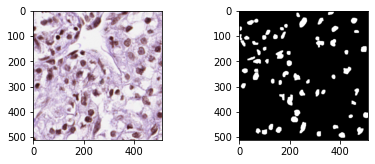

In [ ]:
for i in range(len(x)):
  #print(x.shape,y.shape)
  #r = random.randint(0, len(x)-1)

  fig = plt.figure()
  fig.subplots_adjust(hspace=0.6, wspace=0.6)
  ax = fig.add_subplot(1, 2, 1)
  ax.imshow(np.reshape(x[i],(image_size , image_size,3)))
  ax = fig.add_subplot(1, 2, 2)
  ax.imshow(np.reshape(y[i], (image_size, image_size)), cmap="gray")

## Segnet 

In [ ]:
def Segnet():
  image_shape = (512,512,3)
  inputs= Input(shape=image_shape)
  x=inputs
  #Encoder
  x1=Convolution2D(64,(3,3),strides=1,padding="same")(x)
  x1=BatchNormalization()(x1)
  x1=Activation("relu")(x1)
  x1=Convolution2D(64,(3,3),strides=1,padding="same")(x1)
  x1=BatchNormalization()(x1)
  x1=Activation("relu")(x1)
  p1=MaxPooling2D(pool_size=(2,2))(x1)

  x2=Convolution2D(128,(3,3),strides=1,padding="same")(p1)
  x2=BatchNormalization()(x2)
  x2=Activation("relu")(x2)
  x2=Convolution2D(128,(3,3),strides=1,padding="same")(x2)
  x2=BatchNormalization()(x2)
  x2=Activation("relu")(x2)
  p2=MaxPooling2D(pool_size=(2,2))(x2)

  x3=Convolution2D(256,(3,3),strides=1,padding="same")(p2)
  x3=BatchNormalization()(x3)
  x3=Activation("relu")(x3)
  x3=Convolution2D(256,(3,3),strides=1,padding="same")(x3)
  x3=BatchNormalization()(x3)
  x3=Activation("relu")(x3)
  p3=MaxPooling2D(pool_size=(2,2))(x3)

  x4=Convolution2D(512,(3,3),strides=1,padding="same")(p3)
  x4=BatchNormalization()(x4)
  x4=Activation("relu")(x4)
  x4=Convolution2D(512,(3,3),strides=1,padding="same")(x4)
  x4=BatchNormalization()(x4)
  x4=Activation("relu")(x4)
  p4=MaxPooling2D(pool_size=(2,2))(x4)
  
  bn=Convolution2D(1024,(3,3),strides=1,padding="same")(p4)
  bn=BatchNormalization()(bn)
  bn=Activation("relu")(bn)
  bn=Convolution2D(1024,(3,3),strides=1,padding="same")(p4)
  bn=BatchNormalization()(bn)
  bn=Activation("relu")(bn)

  
  
  x6=UpSampling2D(size=(2,2))(bn)
 
  x6=Convolution2D(512,(3,3),strides=1,padding="same")(x6)
  x6=BatchNormalization()(x6)
  x6=Activation("relu")(x6)
  x6=Convolution2D(512,(3,3),strides=1,padding="same")(x6)
  x6=BatchNormalization()(x6)
  x6=Activation("relu")(x6)

  x7=UpSampling2D(size=(2,2))(x6)
  
  x7=Convolution2D(256,(3,3),strides=1,padding="same")(x7)
  x7=BatchNormalization()(x7)
  x7=Activation("relu")(x7)
  x7=Convolution2D(256,(3,3),strides=1,padding="same")(x7)
  x7=BatchNormalization()(x7)
  x7=Activation("relu")(x7)

  x8=UpSampling2D(size=(2,2))(x7)
  
  x8=Convolution2D(128,(3,3),strides=1,padding="same")(x8)
  x8=BatchNormalization()(x8)
  x8=Activation("relu")(x8)
  x8=Convolution2D(128,(3,3),strides=1,padding="same")(x8)
  x8=BatchNormalization()(x8)
  x8=Activation("relu")(x8)
   
  x9=UpSampling2D(size=(2,2))(x8)
 
  x9=Convolution2D(64,(3,3),strides=1,padding="same")(x9)
  x9=BatchNormalization()(x9)
  x9=Activation("relu")(x9)
  x9=Convolution2D(64,(3,3),strides=1,padding="same")(x9)
  x9=BatchNormalization()(x9)
  x9=Activation("relu")(x9) 


  x9=Convolution2D(1,(1,1),strides=1,padding="same")(x9)
  #x=Reshape((image_shape[0]*image_shape[1],1))(x)
  x9=Activation("sigmoid")(x9)
  
  model = Model(inputs,x9)

  return model


  

  

In [ ]:

model_segnet = Segnet()
adam = optimizers.Adam(lr=0.0001, decay=5*1e-7)
model_segnet.compile(optimizer="adam", loss="binary_crossentropy", metrics=["acc"])
model_segnet.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 512, 512, 3)]     0         
_________________________________________________________________
conv2d (Conv2D)              (None, 512, 512, 64)      1792      
_________________________________________________________________
batch_normalization (BatchNo (None, 512, 512, 64)      256       
_________________________________________________________________
activation (Activation)      (None, 512, 512, 64)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 512, 512, 64)      36928     
_________________________________________________________________
batch_normalization_1 (Batch (None, 512, 512, 64)      256       
_________________________________________________________________
activation_1 (Activation)    (None, 512, 512, 64)      0     

## CuMedVision 

In [ ]:
def CuMedVision():
  image_shape = (512,512,3)
  inputs= Input(shape=image_shape)
  x=inputs
  #Encoder
  x1=Convolution2D(32,(3,3),strides=1,padding="same")(x)
  x1=Activation("relu")(x1)
  x1=Convolution2D(32,(3,3),strides=1,padding="same")(x1)
  x1=Activation("relu")(x1)
  
  p1=MaxPooling2D(pool_size=(2,2))(x1)
  #print(p1)
  x2=Convolution2D(64,(3,3),strides=1,padding="same")(p1)
  x2=Activation("relu")(x2)
  x2=Convolution2D(64,(3,3),strides=1,padding="same")(x2)
  x2=Activation("relu")(x2)
  
  p2=MaxPooling2D(pool_size=(2,2))(x2)
  #print(p2)
  x3=Convolution2D(128,(3,3),strides=1,padding="same")(p2)
  x3=Activation("relu")(x3)
  x3=Convolution2D(128,(3,3),strides=1,padding="same")(x3)
  x3=Activation("relu")(x3)
  x3=Convolution2D(128,(3,3),strides=1,padding="same")(x3)
  x3=Activation("relu")(x3)
  
  p3=MaxPooling2D(pool_size=(2,2))(x3)
  #print(p3)
  x4=Convolution2D(256,(3,3),strides=1,padding="same")(p3)
  x4=Activation("relu")(x4)
  x4=Convolution2D(256,(3,3),strides=1,padding="same")(x4)
  x4=Activation("relu")(x4)
  x4=Convolution2D(256,(3,3),strides=1,padding="same")(x4)
  x4=Activation("relu")(x4)
  
  p4=MaxPooling2D(pool_size=(2,2))(x4)
  #print(p4)

  x5=Convolution2D(256,(3,3),strides=1,padding="same")(p4)
  x5=Activation("relu")(x5)
  x5=Convolution2D(256,(3,3),strides=1,padding="same")(x5)
  x5=Activation("relu")(x5)
  x5=Convolution2D(256,(3,3),strides=1,padding="same")(x5)
  x5=Activation("relu")(x5)
  




  u1=UpSampling2D(size=(16,16))(x5)
  #print(u1)
  u1=Convolution2D(2,(3,3),strides=1,padding="same")(u1)
  u1=Activation("relu")(u1)
  u1=Convolution2D(2,(1,1),strides=1,padding="same")(u1)
  u1=Activation("relu")(u1)
  
  
 
  u2=UpSampling2D(size=(8,8))(x4)
  #print(u2)
  u2=Convolution2D(2,(3,3),strides=1,padding="same")(u2)
  u2=Activation("relu")(u2)
  u2=Convolution2D(2,(1,1),strides=1,padding="same")(u2)
  u2=Activation("relu")(u2)

  
 

  u3=UpSampling2D(size=(4,4))(x3)
  #print(u3)
  u3=Convolution2D(2,(3,3),strides=1,padding="same")(u3)
  u3=Activation("relu")(u3)
  u3=Convolution2D(2,(1,1),strides=1,padding="same")(u3)
  u3=Activation("relu")(u3)
 
  
  
  #u3=Convolution2D(2,(1,1),strides=1,padding="same",activation='sigmoid')(u3)
  
  output = Add()([u1,u2,u3])
 


  output=Convolution2D(1,(1,1),strides=1,padding="same")(output)
  output=Activation("sigmoid")(output)
  model = Model(inputs,output)

  return model


In [ ]:
model_CuMedVision = CuMedVision()
adam = optimizers.Adam(lr=0.0001, decay=5*1e-7)
model_CuMedVision.compile(optimizer="adam", loss="binary_crossentropy", metrics=["acc"])
model_CuMedVision.summary()

## ASPP(normal Convolution)

In [ ]:
def aspp_normalConvolution(x,filters):
  c=Convolution2D(filters,(3,3),strides=1,padding="same",dilation_rate=6)(x)
  c=Activation("relu")(c)
  c=Convolution2D(filters,(1,1),strides=1,padding="same")(c)
  c=Activation("relu")(c)
  c=Convolution2D(filters,(1,1),strides=1,padding="same")(c)
  c=Activation("relu")(c)

  a=Convolution2D(filters,(3,3),strides=1,padding="same",dilation_rate=12)(x)
  a=Activation("relu")(a)
  a=Convolution2D(filters,(1,1),strides=1,padding="same")(a)
  a=Activation("relu")(a)
  a=Convolution2D(filters,(1,1),strides=1,padding="same")(a)
  a=Activation("relu")(a)

  b=Convolution2D(filters,(3,3),strides=1,padding="same",dilation_rate=18)(x)
  b=Activation("relu")(b)
  b=Convolution2D(filters,(1,1),strides=1,padding="same")(b)
  b=Activation("relu")(b)
  b=Convolution2D(filters,(1,1),strides=1,padding="same")(b)
  b=Activation("relu")(b)

  d=Convolution2D(filters,(3,3),strides=1,padding="same",dilation_rate=24)(x)
  d=Activation("relu")(d)
  d=Convolution2D(filters,(1,1),strides=1,padding="same")(d)
  d=Activation("relu")(d)
  d=Convolution2D(filters,(1,1),strides=1,padding="same")(d)
  d=Activation("relu")(d)

  out=Concatenate()([c,a,b,d])

  out=Convolution2D(256,(1,1),strides=1,padding="same")(out)
  out=Activation("relu")(out)

  return out

  

## ASPP (Separable Convolution)

In [ ]:
def aspp_separableConvolution(x,filters):
  c=SeparableConvolution2D(filters,(3,3),strides=1,padding="same",dilation_rate=6)(x)
  c=Activation("relu")(c)
  c=SeparableConvolution2D(filters,(1,1),strides=1,padding="same")(c)
  c=Activation("relu")(c)
  c=SeparableConvolution2D(filters,(1,1),strides=1,padding="same")(c)
  c=Activation("relu")(c)

  a=SeparableConvolution2D(filters,(3,3),strides=1,padding="same",dilation_rate=12)(x)
  a=Activation("relu")(a)
  a=SeparableConvolution2D(filters,(1,1),strides=1,padding="same")(a)
  a=Activation("relu")(a)
  a=SeparableConvolution2D(filters,(1,1),strides=1,padding="same")(a)
  a=Activation("relu")(a)

  b=SeparableConvolution2D(filters,(3,3),strides=1,padding="same",dilation_rate=18)(x)
  b=Activation("relu")(b)
  b=SeparableConvolution2D(filters,(1,1),strides=1,padding="same")(b)
  b=Activation("relu")(b)
  b=SeparableConvolution2D(filters,(1,1),strides=1,padding="same")(b)
  b=Activation("relu")(b)

  d=SeparableConvolution2D(filters,(3,3),strides=1,padding="same",dilation_rate=24)(x)
  d=Activation("relu")(d)
  d=SeparableConvolution2D(filters,(1,1),strides=1,padding="same")(d)
  d=Activation("relu")(d)
  d=SeparableConvolution2D(filters,(1,1),strides=1,padding="same")(d)
  d=Activation("relu")(d)

  out=Concatenate()([c,a,b,d])

  out=SeparableConvolution2D(256,(1,1),strides=1,padding="same")(out)
  out=Activation("relu")(out)

  return out

  

## SCPP net

In [ ]:
def SCPPnet():
  image_shape = (512,512,3)
  inputs= Input(shape=image_shape)
  x=inputs
  #Encoder
  x1=Convolution2D(32,(3,3),strides=1,padding="same")(x)
  x1=Activation("relu")(x1)
  x1=Convolution2D(32,(3,3),strides=1,padding="same")(x1)
  x1=Activation("relu")(x1)
  
  p1=MaxPooling2D(pool_size=(2,2))(x1)
  #print(p1)
  x2=Convolution2D(64,(3,3),strides=1,padding="same")(p1)
  x2=Activation("relu")(x2)
  x2=Convolution2D(64,(3,3),strides=1,padding="same")(x2)
  x2=Activation("relu")(x2)
  
  p2=MaxPooling2D(pool_size=(2,2))(x2)
  #print(p2)
  x3=Convolution2D(128,(3,3),strides=1,padding="same")(p2)
  x3=Activation("relu")(x3)
  x3=Convolution2D(128,(3,3),strides=1,padding="same")(x3)
  x3=Activation("relu")(x3)
  x3=Convolution2D(128,(3,3),strides=1,padding="same")(x3)
  x3=Activation("relu")(x3)
  
  p3=MaxPooling2D(pool_size=(2,2))(x3)
  #print(p3)
  x4=Convolution2D(256,(3,3),strides=1,padding="same")(p3)
  x4=Activation("relu")(x4)
  x4=Convolution2D(256,(3,3),strides=1,padding="same")(x4)
  x4=Activation("relu")(x4)
  x4=Convolution2D(256,(3,3),strides=1,padding="same")(x4)
  x4=Activation("relu")(x4)
  p4=MaxPooling2D(pool_size=(2,2))(x4)

  #aspp
  p4=aspp_separableConvolution(p4,512)
  
  



  u1=UpSampling2D(size=(16,16))(p4)
  #print(u1)
  u1=Convolution2D(2,(3,3),strides=1,padding="same")(u1)
  u1=Activation("relu")(u1)
  u1=Convolution2D(2,(1,1),strides=1,padding="same")(u1)
  u1=Activation("relu")(u1)
  
  
  
  u2=UpSampling2D(size=(8,8))(x4)
  #print(u2)
  u2=Convolution2D(2,(3,3),strides=1,padding="same")(u2)
  u2=Activation("relu")(u2)
  u2=Convolution2D(2,(1,1),strides=1,padding="same")(u2)
  u2=Activation("relu")(u2)

  
 
 

  u3=UpSampling2D(size=(4,4))(x3)
  #print(u3)
  u3=Convolution2D(2,(3,3),strides=1,padding="same")(u3)
  u3=Activation("relu")(u3)
  u3=Convolution2D(2,(1,1),strides=1,padding="same")(u3)
  u3=Activation("relu")(u3)

  
  
  
  
  output = Add()([u1,u2,u3])
 


  output=Convolution2D(1,(1,1),strides=1,padding="same")(output)
  output=Activation("sigmoid")(output)
  model = Model(inputs,output)

  return model

   


  




  




In [ ]:
model_SCPPnet = SCPPnet()
adam = optimizers.Adam(lr=0.0001, decay=5*1e-7)
model_SCPPnet.compile(optimizer="adam", loss="binary_crossentropy", metrics=["acc"])
model_SCPPnet.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 512, 512, 3) 0                                            
__________________________________________________________________________________________________
conv2d_38 (Conv2D)              (None, 512, 512, 32) 896         input_2[0][0]                    
__________________________________________________________________________________________________
activation_38 (Activation)      (None, 512, 512, 32) 0           conv2d_38[0][0]                  
__________________________________________________________________________________________________
conv2d_39 (Conv2D)              (None, 512, 512, 32) 9248        activation_38[0][0]              
____________________________________________________________________________________________

## Unet

In [ ]:
def down_block(x,filters,kernel_size=(3,3), padding="same",strides = 1):
    c = Conv2D(filters, kernel_size, padding=padding, strides=strides, activation="relu")(x)
    c = Conv2D(filters, kernel_size, padding=padding, strides=strides, activation="relu")(c)
    p = MaxPooling2D((2, 2), strides=(2, 2),padding="same")(c)
    p = Dropout(0.2)(p)
    return c, p

def up_block(x, skip, filters, kernel_size=(3, 3), padding="same", strides=1):
    us = UpSampling2D((2, 2))(x)
    concat = Concatenate()([us, skip])
    c = Conv2D(filters, kernel_size, padding=padding, strides=strides, activation="relu")(concat)
    c = Conv2D(filters, kernel_size, padding=padding, strides=strides, activation="relu")(c)
    c = Dropout(0.2)(c)
    return c

def bottleneck(x, filters, kernel_size=(3, 3), padding="same", strides=1):
    c = Conv2D(filters, kernel_size, padding=padding, strides=strides, activation="relu")(x)
    c = Conv2D(filters, kernel_size, padding=padding, strides=strides, activation="relu")(c)
    c = Dropout(0.2)(c)
    return c

In [ ]:
def Unet():
    f = [64, 128, 256,512,1024]
    inputs = Input((image_size, image_size,3))
    #print(inputs.shape)
    #inputs = np.expand_dims(inputs, axis=-1)
    p0 = inputs
    c1, p1 = down_block(p0, f[0]) #128 -> 64
    c2, p2 = down_block(p1, f[1]) #64 -> 32
    c3, p3 = down_block(p2, f[2]) #32 -> 16
    c4, p4 = down_block(p3, f[3]) #16->8
    
    bn = bottleneck(p4, f[4])
    
    u1 = up_block(bn, c4, f[3]) #8 -> 16
    u2 = up_block(u1, c3, f[2]) #16 -> 32
    u3 = up_block(u2, c2, f[1]) #32 -> 64
    u4 = up_block(u3, c1, f[0]) #64 -> 128
    
    outputs = Conv2D(1, (1, 1), padding="same", activation="sigmoid")(u4)
    #nputs = np.expand_dims(inputs, axis=-1)
    #outputs = np.expand_dims(outputs, axis=-1)
    model = Model(inputs, outputs)
    return model

In [ ]:
model_Unet = Unet()
adam = optimizers.Adam(lr=0.0001 , decay=5*1e-7)
model_Unet.compile(optimizer="adam", loss="binary_crossentropy", metrics=["acc"])
model_Unet.summary()

Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 512, 512, 3) 0                                            
__________________________________________________________________________________________________
conv2d_68 (Conv2D)              (None, 512, 512, 64) 1792        input_3[0][0]                    
__________________________________________________________________________________________________
conv2d_69 (Conv2D)              (None, 512, 512, 64) 36928       conv2d_68[0][0]                  
__________________________________________________________________________________________________
max_pooling2d_12 (MaxPooling2D) (None, 256, 256, 64) 0           conv2d_69[0][0]                  
____________________________________________________________________________________________

## Attention Unet

In [ ]:
from tensorflow.keras.layers import Conv2D, MaxPooling2D, UpSampling2D, BatchNormalization, Reshape, Permute, Activation, Input, \
    add, multiply
from tensorflow.keras.layers import concatenate, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.layers import concatenate
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.layers import Lambda
import tensorflow.keras.backend as K

In [ ]:
def attention_block_2d(x, g, inter_channel):
    # theta_x(?,g_height,g_width,inter_channel)

    theta_x = Conv2D(filters=inter_channel, kernel_size=(1, 1), strides=(1, 1),padding='same')(x)

    # phi_g(?,g_height,g_width,inter_channel)

    phi_g = Conv2D(filters=inter_channel, kernel_size=(1, 1), strides=(1, 1),padding='same')(g)

    # f(?,g_height,g_width,inter_channel)

    f = Activation('relu')(add([theta_x, phi_g]))

    # psi_f(?,g_height,g_width,1)

    psi_f = Conv2D(filters=1, kernel_size=(1, 1), strides=(1, 1),padding='same')(f)

    rate = Activation('sigmoid')(psi_f)

    # rate(?,x_height,x_width)

    # att_x(?,x_height,x_width,x_channel)

    att_x = multiply([x, rate])

    return att_x
    
def attention_up_and_concate(down_layer, layer):

    in_channel = down_layer.get_shape().as_list()[3]

    # up = Conv2DTranspose(out_channel, [2, 2], strides=[2, 2])(down_layer)
    up = UpSampling2D(size=(2, 2),interpolation = 'nearest')(down_layer)  

    layer = attention_block_2d(x=layer, g=up, inter_channel=in_channel // 4)

    concate = concatenate([up, layer], axis=3)

    return concate

def down_block(x, filt):
    cn = Conv2D(filters = filt, kernel_size=(3, 3), strides=1, padding='same', activation='relu',
               use_bias=True, kernel_initializer='glorot_normal')(x)
    d1 =  Dropout(0.2)(cn)
    cn1 = Conv2D(filters = filt,  kernel_size=(3, 3), strides=1, padding='same', activation='relu',
               use_bias=True, kernel_initializer='glorot_normal')(d1)
    p = MaxPooling2D((2, 2), strides=(2, 2),padding='same')(cn1)
    return cn1, p

def up_block(x, skip, filt):
    concat = attention_up_and_concate(x, skip)
    cnn = Conv2D(filters=filt, kernel_size=(3, 3), strides=1, padding='same', activation='relu',
               use_bias=True, kernel_initializer='glorot_normal')(concat)
    d2 =  Dropout(0.2)(cnn)     
    cnn1 = Conv2D(filters=filt, kernel_size=(3, 3), strides=1, padding='same', activation='relu',
               use_bias=True, kernel_initializer='glorot_normal')(d2)
    return cnn1

def bottleneck(x, filt):
    cnt = Conv2D(filters=filt, kernel_size=(3, 3), strides=1, padding='same', activation='relu',
               use_bias=True, kernel_initializer='glorot_normal')(x)
    d3 = Dropout(0.2)(cnt)
    cnt1 = Conv2D(filters=filt, kernel_size=(3, 3), strides=1, padding='same', activation='relu',
               use_bias=True, kernel_initializer='glorot_normal')(d3)
    return cnt1


def att_UNet():
    f = [64, 128, 256, 512, 1024]
    #inputs = keras.layers.Input((image_size, image_size, 3))
    inputs= Input((512,512,3))
    
    # p0 = inputs
    c1, p1 = down_block(inputs, f[0]) #128 -> 64
    c2, p2 = down_block(p1, f[1]) #64 -> 32
    c3, p3 = down_block(p2, f[2]) #32 -> 16
    c4, p4 = down_block(p3, f[3]) #16->8
    pd1 = Dropout(0.2)(p4)   
    bn = bottleneck(pd1, f[4])
    pd2 = Dropout(0.2)(bn)   
    u1 = up_block(pd2, c4, f[3]) #8 -> 16
    u2 = up_block(u1, c3, f[2]) #16 -> 32
    u3 = up_block(u2, c2, f[1]) #32 -> 64
    u4 = up_block(u3, c1, f[0]) #64 -> 128
    
    outputs = Conv2D(filters=1, kernel_size=(1,1), strides=(1,1), padding='same', activation='sigmoid')(u4)
    model = Model(inputs=[inputs], outputs=[outputs])
    return model

In [ ]:
smooth = 1
def dice_coef(y_true, y_pred):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)



model_attUnet = att_UNet()
adam = keras.optimizers.Adam(lr = 0.001)
model_attUnet.compile(optimizer = "adam" , loss = 'binary_crossentropy' , metrics = ["acc"])
model_attUnet.summary()

Model: "model_4"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_5 (InputLayer)            [(None, 512, 512, 3) 0                                            
__________________________________________________________________________________________________
conv2d_99 (Conv2D)              (None, 512, 512, 64) 1792        input_5[0][0]                    
__________________________________________________________________________________________________
dropout_16 (Dropout)            (None, 512, 512, 64) 0           conv2d_99[0][0]                  
__________________________________________________________________________________________________
conv2d_100 (Conv2D)             (None, 512, 512, 64) 36928       dropout_16[0][0]                 
____________________________________________________________________________________________

## Dist

In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow.keras import *
from  tensorflow.keras.initializers import *
from tensorflow.keras.layers import *
import tensorflow.keras.backend as K
from tensorflow.python import control_flow_ops

def CropAndMerge(Input1, Input2, name="bridge"):
        """
        Crop input1 so that it matches input2 and then
        return the concatenation of both channels.
        """
        Size1_x = (Input1).shape[1]
        Size2_x = (Input2).shape[1]

        Size1_y = (Input1).shape[2]
        Size2_y = (Input2).shape[2]
   
        diff_x = tf.divide(tf.subtract(Size1_x, Size2_x), 2)
        diff_y = tf.divide(tf.subtract(Size1_y, Size2_y), 2)
        diff_x = tf.cast(diff_x, tf.int32)
        Size2_x = tf.cast(Size2_x, tf.int32)
        diff_y = tf.cast(diff_y, tf.int32)
        Size2_y = tf.cast(Size2_y, tf.int32)
        crop = tf.slice(Input1, [0, diff_x, diff_y, 0], [-1, Size2_x, Size2_y, -1])
        concat = tf.concat([crop, Input2], axis=3)

        return concat


def bn_conv_relu(input, filters):
    
    x = Conv2D(filters,kernel_size=(3,3), strides=(1, 1), activation='relu', padding='same',use_bias=True, kernel_initializer='glorot_normal',bias_initializer=Constant(0.1))(input)
    x = BatchNormalization(epsilon=1e-3,beta_initializer=Constant(0.0),gamma_initializer=Constant(1.0),momentum=0.5)(x)
    x = Conv2D(filters,kernel_size=(3,3), strides=(1, 1), activation='relu', padding='same',use_bias=True, kernel_initializer='glorot_normal',bias_initializer=Constant(0.1))(x)
    x = BatchNormalization(epsilon=1e-3,beta_initializer=Constant(0.0),gamma_initializer=Constant(1.0),momentum=0.5)(x)
    
    return x

def bn_upconv_relu(input, filters,conc):

    x = Conv2DTranspose(filters=filters, kernel_size=(2, 2),activation='relu', strides=(2, 2), padding='same',kernel_initializer='glorot_normal',bias_initializer=Constant(0.1),use_bias=True)(input)
    x = CropAndMerge(Input1=x,Input2=conc,name='bridge')
    
    return x

def dist(
    
    num_classes=1,
    output_activation='sigmoid'):

    inputs = Input((512,512,3))   
    
    filters = [32,64,128,256,512]
 

    # for l in range(num_layers):
    x_conv1 = bn_conv_relu(inputs, filters[0])
    x_pool1 = MaxPooling2D((2, 2), strides=(2, 2),padding="same")(x_conv1)
    x_conv2 = bn_conv_relu(x_pool1, filters[1])
    x_pool2 = MaxPooling2D((2, 2), strides=(2, 2),padding="same")(x_conv2)  
    x_conv3 = bn_conv_relu(x_pool2, filters[2])
    x_pool3 = MaxPooling2D((2, 2), strides=(2, 2),padding="same")(x_conv3)
    x_conv4 = bn_conv_relu(x_pool3, filters[3])
    x_pool4 = MaxPooling2D((2, 2), strides=(2, 2),padding="same")(x_conv4)
    x_conv5 = bn_conv_relu(x_pool4, filters[4])

# upsampling in the form of convtranspose

    x_tconv5 = bn_upconv_relu(x_conv5, filters[3],x_conv4)
    u_conv4 = bn_conv_relu(x_tconv5, filters[3])
    x_tconv4 = bn_upconv_relu(u_conv4, filters[2],x_conv3)
    u_conv3 = bn_conv_relu(x_tconv4, filters[2])
    x_tconv3 = bn_upconv_relu(u_conv3, filters[1],x_conv2)
    u_conv2 = bn_conv_relu(x_tconv3, filters[1])
    x_tconv2 = bn_upconv_relu(u_conv2, filters[0],x_conv1)
    u_conv1 = bn_conv_relu(x_tconv2, filters[0])
              
    outputs = Conv2D(num_classes, kernel_size=(1,1), strides=(1,1), activation=output_activation, padding='same') (u_conv1)       
    
    model = Model(inputs=[inputs], outputs=[outputs])
    return model

smooth = 1.
def dice_coef(y_true, y_pred):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)

def dice_coef_loss(y_true, y_pred):
    return 1-dice_coef(y_true, y_pred)

def binary_cross(y_true, y_pred):
    return K.binary_crossentropy(y_true,y_pred)


model_dist = dist()
adam = keras.optimizers.Adam(lr = 0.001,decay=5*1e-6)
model_dist.compile(optimizer = "adam" , loss = "binary_crossentropy" , metrics = ["acc"])
model_dist.summary()

Model: "model_5"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_6 (InputLayer)            [(None, 512, 512, 3) 0                                            
__________________________________________________________________________________________________
conv2d_126 (Conv2D)             (None, 512, 512, 32) 896         input_6[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 512, 512, 32) 128         conv2d_126[0][0]                 
__________________________________________________________________________________________________
conv2d_127 (Conv2D)             (None, 512, 512, 32) 9248        batch_normalization[0][0]        
____________________________________________________________________________________________

## Counting FLOPS 


In [ ]:
import tensorflow as tf
import keras.backend as K

run_meta = tf.compat.v1.RunMetadata()
with tf.compat.v1.Session(graph=tf.Graph()) as sess:
    tf.compat.v1.keras.backend.set_session(sess)
    net = Segnet()

    opts = tf.compat.v1.profiler.ProfileOptionBuilder.float_operation()    
    flops = tf.compat.v1.profiler.profile(sess.graph, run_meta=run_meta, cmd='op', options=opts)

    opts = tf.compat.v1.profiler.ProfileOptionBuilder.trainable_variables_parameter()    
    params = tf.compat.v1.profiler.profile(sess.graph, run_meta=run_meta, cmd='op', options=opts)

    print("{:,} --- {:,}".format(flops.total_float_ops, params.total_parameters))

47,065,663 --- 23,538,689


## Training 

In [ ]:
train_gen = DataGen(train_ids, train_path, image_size=image_size, batch_size=batch_size)
valid_gen = DataGen(val_ids, val_path, image_size=image_size, batch_size=batch_size)
print(valid_gen)
train_steps = int(np.ceil(len(train_ids)/float(batch_size)))
valid_steps = int(np.ceil(len(val_ids)/float(batch_size)))
#print(len(train_ids))
callbacks = [tensorflow.keras.callbacks.EarlyStopping(patience=10,monitor='val_loss'),tensorflow.keras.callbacks.TensorBoard(log_dir='logs')]
history = model_SCPPnet.fit_generator(train_gen, validation_data=valid_gen, steps_per_epoch=train_steps, validation_steps=valid_steps, 
                    epochs=100,callbacks=callbacks)
#history = model_segnet.fit_generator(train_gen, validation_data=valid_gen, steps_per_epoch=train_steps, validation_steps=valid_steps, 
#                    epochs=100,callbacks=callbacks)
#history = model_Unet.fit_generator(train_gen, validation_data=valid_gen, steps_per_epoch=train_steps, validation_steps=valid_steps, 
#                    epochs=100,callbacks=callbacks)
#history = model_CuMedVision.fit_generator(train_gen, validation_data=valid_gen, steps_per_epoch=train_steps, validation_steps=valid_steps, 
#                    epochs=100,callbacks=callbacks)
#history = model_attUnet.fit_generator(train_gen, validation_data=valid_gen, steps_per_epoch=train_steps, validation_steps=valid_steps, 
#                    epochs=100,callbacks=callbacks)
#history = model_dist.fit_generator(train_gen, validation_data=valid_gen, steps_per_epoch=train_steps, validation_steps=valid_steps, 
#                    epochs=100,callbacks=callbacks)


Epoch 1/100
200/200 [==============================] - 19s 94ms/step - loss: 0.3601 - acc: 0.8865 - val_loss: 0.4477 - val_acc: 0.8346
Epoch 2/100
200/200 [==============================] - 18s 92ms/step - loss: 0.2892 - acc: 0.8865 - val_loss: 0.3365 - val_acc: 0.8346
Epoch 3/100
200/200 [==============================] - 18s 91ms/step - loss: 0.2311 - acc: 0.8865 - val_loss: 0.2935 - val_acc: 0.8346
Epoch 4/100
200/200 [==============================] - 18s 91ms/step - loss: 0.2410 - acc: 0.8865 - val_loss: 0.3052 - val_acc: 0.8346
Epoch 5/100
200/200 [==============================] - 18s 92ms/step - loss: 0.2204 - acc: 0.9039 - val_loss: 0.3120 - val_acc: 0.8638
Epoch 6/100
200/200 [==============================] - 18s 91ms/step - loss: 0.1993 - acc: 0.9226 - val_loss: 0.2512 - val_acc: 0.8934
Epoch 7/100
200/200 [==============================] - 18s 92ms/step - loss: 0.1881 - acc: 0.9286 - val_loss: 0.2840 - val_acc: 0.8857
Epoch 8/100
200/200 [==============================] - 

## Saving and Loading weights 

In [ ]:
 #model_SCPPnet.save_weights('/content/gdrive/My Drive/SCPPnet.h5')
model_SCPPnet.load_weights('/content/gdrive/My Drive/SCPPnet.h5')
test_gen = DataGen(test_ids,test_path,image_size=image_size,batch_size=15)
## Dataset for prediction
x, y = test_gen.__getitem__(0)

ValueError: ignored

## Prediction

In [ ]:
result = model_Cumedvision_mod.predict(x)

result = result >0.5

result = 1*result

print(len(x))
y=y.astype(int)

15


## Predicted Images 

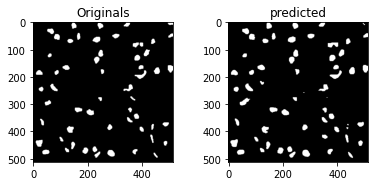

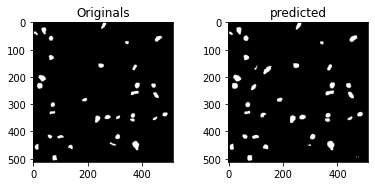

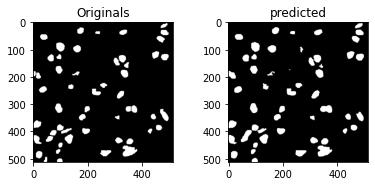

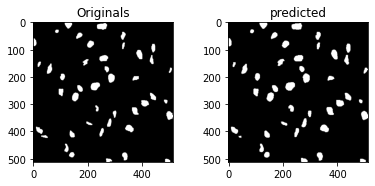

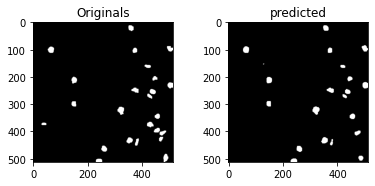

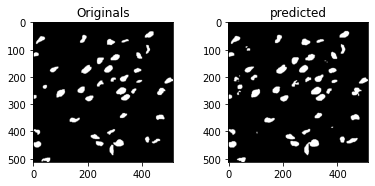

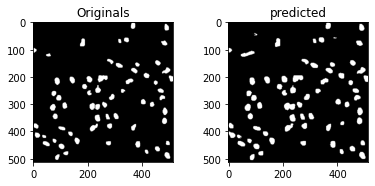

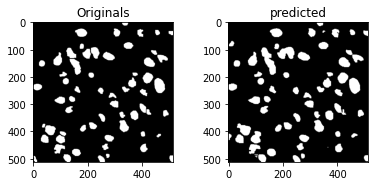

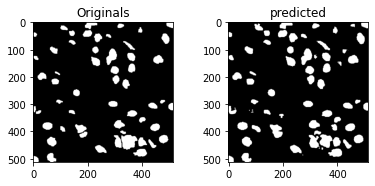

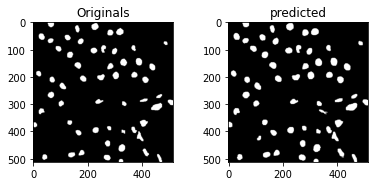

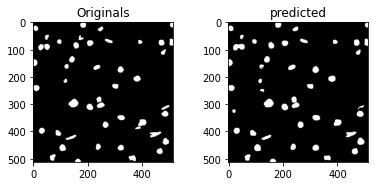

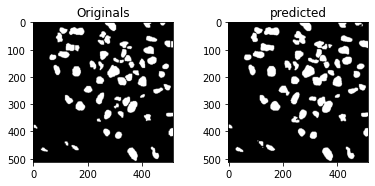

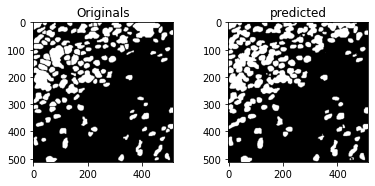

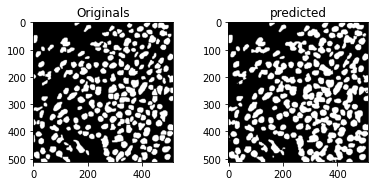

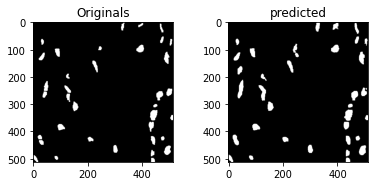

In [ ]:
for i in range(len(x)):
  fig = plt.figure()
  fig.subplots_adjust(hspace=0.4, wspace=0.4)
  #r = random.randint(0, len(x)-1)
  ax = fig.add_subplot(1, 2, 1)
  ax.set_title('Originals')
  ax.imshow(np.reshape(y[i]*255, (image_size, image_size)),cmap = "gray")
  #fig.savefig('plot.png')

  ax = fig.add_subplot(1, 2, 2)
  ax.set_title("predicted")
  ax.imshow(np.reshape(result[i]*255, (image_size, image_size)), cmap="gray")
  img =np.reshape(result[i]*255, (image_size, image_size)).astype('float32')
  #img = cv2.resize(img,(400,400))
  #path4 = '/content/gdrive/My Drive/final_dataset/results/cumed_norm/Predicted/'
  #cv2.imwrite(path4+'cu_norgtk'+str(i)+'.png',img)
  #img=0
  

## Accuracy

In [ ]:
def accuracy(gt,mask):
  
  img = cv2.bitwise_xor(gt,mask)
  n = np.count_nonzero(img)
  sum = mask.size
  k = sum-n
  acc = k/sum
  #print(k)
  print(acc)
  return(acc)

s=0  
for i in range(len(y)):
  
  s = s+accuracy(y[i],result[i])
acc = s/len(y)
print("final accuracy",acc)

0.9859466552734375
0.9881820678710938
0.9845542907714844
0.9886322021484375
0.9920997619628906
0.9851417541503906
0.981842041015625
0.9766349792480469
0.9741401672363281
0.9834747314453125
0.9892845153808594
0.9788665771484375
0.9601669311523438
0.94073486328125
0.985443115234375
final accuracy 0.9796763102213542


## Precision

In [ ]:
def precision(gt,mask):
  gt = gt.flatten()
  mask = mask.flatten()
  tn,fp,fn,tp = confusion_matrix(gt,mask).ravel()
  prec = tp/(tp+fp)
  print(prec)
  return(prec)
  
sum = 0
for i in range(len(y)):
  sum = sum + precision(y[i],result[i])
prec = sum/len(y)
print("final precision",prec)

0.8352679281284783
0.7342630623746299
0.8746360212757697
0.8494799324729074
0.9097826086956522
0.8165875593305021
0.797753292588448
0.8548927954476171
0.8361176758210415
0.8216189207195204
0.8903065745171008
0.8690549405494055
0.8752418946678973
0.8508809357796255
0.7612028689873002
final precision 0.8384724674237266


## Recall

In [ ]:
def recall(gt,mask):
  gt = gt.flatten()
  mask = mask.flatten()
  tn,fp,fn,tp = confusion_matrix(gt,mask).ravel()
  rec = tp/(tp+fn)
  print(rec)
  return(rec)
  
sum = 0
for i in range(len(y)):
  sum = sum + recall(y[i],result[i])
rec = sum/len(y)
print("final precision",rec)

0.9647382920110192
0.9605148069473948
0.9648792187767689
0.9863420803035093
0.7972513267111172
0.9864799613713182
0.9967197246719725
0.9878761191839132
0.9763369916893992
0.9975733063700708
0.9405891163255118
0.9874796179827626
0.9661342797988761
0.9854523978835469
0.984091875797533
final precision 0.9654972743883143


## F1-Score

In [ ]:
def f1_score():
  f1 = 2*(prec*rec)/(prec+rec)
  print(f1)
f1_score()

0.8975127056555703


## AJI Score 

In [ ]:
def get_fast_aji(true, pred):
    """
    AJI version distributed by MoNuSeg, has no permutation problem but suffered from 
    over-penalisation similar to DICE2
    Fast computation requires instance IDs are in contiguous orderding i.e [1, 2, 3, 4] 
    not [2, 3, 6, 10]. Please call `remap_label` before hand and `by_size` flag has no 
    effect on the result.
    """
    true = np.copy(true) # ? do we need this
    pred = np.copy(pred)
    true_id_list = list(np.unique(true))
    pred_id_list = list(np.unique(pred))

    true_masks = [None,]
    for t in true_id_list[1:]:
        t_mask = np.array(true == t, np.uint8)
        true_masks.append(t_mask)
    
    pred_masks = [None,]
    for p in pred_id_list[1:]:
        p_mask = np.array(pred == p, np.uint8)
        pred_masks.append(p_mask)
    
    # prefill with value
    pairwise_inter = np.zeros([len(true_id_list) -1, 
                               len(pred_id_list) -1], dtype=np.float64)
    pairwise_union = np.zeros([len(true_id_list) -1, 
                               len(pred_id_list) -1], dtype=np.float64)

    # caching pairwise
    for true_id in true_id_list[1:]: # 0-th is background
        t_mask = true_masks[true_id]
        pred_true_overlap = pred[t_mask > 0]
        pred_true_overlap_id = np.unique(pred_true_overlap)
        pred_true_overlap_id = list(pred_true_overlap_id)
        for pred_id in pred_true_overlap_id:
            if pred_id == 0: # ignore
                continue # overlaping background
            p_mask = pred_masks[pred_id]
            total = (t_mask + p_mask).sum()
            inter = (t_mask * p_mask).sum()
            pairwise_inter[true_id-1, pred_id-1] = inter
            pairwise_union[true_id-1, pred_id-1] = total - inter
    #
    pairwise_iou = pairwise_inter / (pairwise_union + 1.0e-6)
    # pair of pred that give highest iou for each true, dont care 
    # about reusing pred instance multiple times
    paired_pred = np.argmax(pairwise_iou, axis=1)
    pairwise_iou = np.max(pairwise_iou, axis=1)
    # exlude those dont have intersection
    paired_true = np.nonzero(pairwise_iou > 0.0)[0]
    paired_pred = paired_pred[paired_true]
    # print(paired_true.shape, paired_pred.shape)
    overall_inter = (pairwise_inter[paired_true, paired_pred]).sum()
    overall_union = (pairwise_union[paired_true, paired_pred]).sum()
    #
    paired_true = (list(paired_true + 1)) # index to instance ID
    paired_pred = (list(paired_pred + 1))
    # add all unpaired GT and Prediction into the union
    unpaired_true = np.array([idx for idx in true_id_list[1:] if idx not in paired_true])
    unpaired_pred = np.array([idx for idx in pred_id_list[1:] if idx not in paired_pred])
    for true_id in unpaired_true:
        overall_union += true_masks[true_id].sum()
    for pred_id in unpaired_pred:
        overall_union += pred_masks[pred_id].sum()
    #
    aji_score = overall_inter / overall_union
    return aji_score

In [ ]:
print( get_fast_aji(y,result))

0.8290581470960676


## Accuracy And Loss Graph

dict_keys(['loss', 'acc', 'val_loss', 'val_acc'])


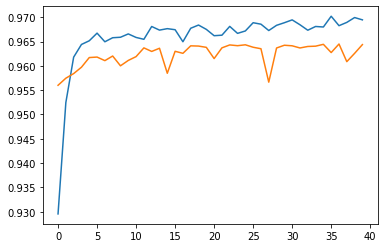

In [ ]:
print(history.history.keys())
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.show()

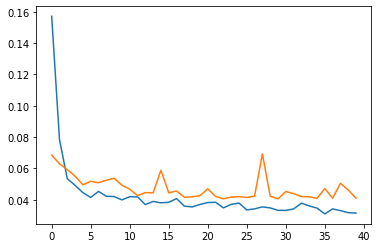

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.show()